In [ ]:
## Chapter 5.1 LangGraph
"""
■LangGraphの構成要素
LangGraphの構成要素は以下です。
・ステートグラフ（State Graph）：グラフとステートが入る入れ物です。
・グラフ（Graph）：処理の流れです。
    ・ノード（Node）：グラフ内の各処理ステップ（コンポーネント）を指します。
    ・エッジ（Edge）：ノード間の接続です。
・ステート（State）：ノード間で受け渡すデータです。

■LangGraphの特徴
LangGraphには、以下のような特徴があります。
・制御構造のサポート：チェーンのように一方向へ進む処理に加え、ループや条件分岐を含むフローを作成可能です。
・状態を持つ：ノード間で共有される状態（ステート）を持ちます。各ノードがステートを参照・更新することで、ステートフルなアプリを実現できます。
・人間の介入：フローの途中で人間が介入し、ノードの次のアクションを制御できます。
"""

# Chapter 5.3 準備
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [5]:
# Chapter 5.4 ステートグラフの作成
"""状態を保持する「ステート」を定義して、ステートとグラフを入れる「ステートグラフ」を作成します。"""
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
"""
・ステートは、TypedDict を継承したクラスとして定義します。
・属性には、ノード間で共有するデータを定義します。ここでは messages というリストを属性として定義しています。
・Annotated で、ノードが属性を更新する方法を指定できます。デフォルトは上書きですが、今回は add_messages 関数を指定しています。
　この関数は「リストに、ノードの実行結果を要素として追加する」処理を行います。"""
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
"""StateGraph(State) で、ステートを持つステートグラフを作成します。この入れ物にグラフを作成していきます。"""
graph_builder = StateGraph(State)

In [6]:
# Chapter 5.5 グラフの作成
"""チャットボットノード1つだけを持つグラフを作成します。"""

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
"""
・ノードは状態を受け取り、状態を更新する値を返します。
    ・引数：State を受け取ります。State の messages 属性にはユーザーからの質問（HumanMessage 型）が格納されています。
    ・戻り値：言語モデルからの回答（AIMessage型）を返します。
・ノードの実行結果は、State の add_messages 関数で処理されます。
  結果は [HumanMessage, AIMessage] のリストとなります。
  今回はノードが1つだけですが、後続のノードがある場合には、この「質問と答え」のリストをもとに、続きの処理を行うことになります。
"""
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
"""グラフにチャットボットノードを追加します。この段階では、ノードが何にも接続されず、単独で存在している状態となります。"""
graph_builder.add_node("chatbot", chatbot)

"""開始ノードと終了ノードを指定することで、ノードがグラフに接続された状態となります。"""
# 開始ノードの指定
graph_builder.set_entry_point("chatbot")
# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
"""最後に、compile() メソッドで実行可能なステートグラフを作成します。"""
graph = graph_builder.compile()

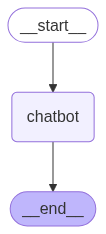

In [7]:
# ステートグラフの可視化
"""LangChainには、ステートグラフを可視化する機能が用意されています。"""

# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Chapter 5.6 動作確認
"""グラフを実行して動作確認を行いましょう。"""

# グラフの実行
response = graph.invoke({"messages": [("user", "光の三原色は？")]})

# 結果の表示
print(response)

{'messages': [HumanMessage(content='光の三原色は？', additional_kwargs={}, response_metadata={}, id='8fa99f73-5350-4520-a99b-5947e5d1d44f'), AIMessage(content='光の三原色は、赤（Red）、緑（Green）、青（Blue）の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。この原理は、ディスプレイやテレビなどの光を使った技術に広く利用されています。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 14, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'finish_reason': 'stop', 'logprobs': None}, id='run-154cb20b-dbf1-4226-a760-9230f05ad144-0', usage_metadata={'input_tokens': 14, 'output_tokens': 73, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [9]:
# 言語モデルからの回答のみを表示
"""言語モデルからの回答のみを表示するには、messages リストの末尾の1要素を -1 で取り出します。"""

# 言語モデルからの回答のみを表示
print(response["messages"][-1].content)

光の三原色は、赤（Red）、緑（Green）、青（Blue）の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。この原理は、ディスプレイやテレビなどの光を使った技術に広く利用されています。


In [10]:
# Chapter 5.7 チャットボットシステムの作成
"""作成したステートグラフを使って、ユーザーからの質問を受け取って回答を行う、チャットボットシステムを作成しましょう。
あわせて、結果をストリーミングで得る方法についても確認します。"""

# グラフの実行と結果の表示
## グラフの実行と結果の表示を行う関数
"""
グラフの実行と結果の表示を行う関数を定義します。結果をストリーミングで得るには stream() メソッドでグラフを実行します。
グラフの実行結果を for ループで受け取って、結果 value["messages"][-1].content を表示します。
"""
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            print("回答:", value["messages"][-1].content, flush=True)

# チャットボットのループ
"""
■連続した対話は行えない
チャットボットシステムでは、1回のループごとに、グラフが開始から終了まで実行されます。
グラフは記憶を持たない（State のデータが破棄されてしまう）ため、連続した対話は行えません。確認してみましょう。
"""
while True:
    """input 関数で受け取った質問を stream_graph_updates 関数に渡しています。"""
    user_input = input("質問:")
    if user_input.strip()=="":
        """空行が入力されたら終了"""
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)

質問: aで始まる英単語を5つ教えて
回答: もちろんです！以下は「a」で始まる英単語の例です：

1. Apple（リンゴ）
2. Adventure（冒険）
3. Amazing（素晴らしい）
4. Artist（アーティスト）
5. Animal（動物）

他にも知りたい単語があれば教えてください！
質問: 3つ目の英単語はなんですか？
回答: 「3つ目の英単語」というのは特定の文脈やリストがないとわかりませんが、一般的に「3つ目」という表現は、何かを順番に数えるときに使います。もし特定の単語リストやテーマがある場合、それを教えていただければ、その文脈に合わせた英単語をお答えできます。例えば、動物の名前や食べ物の名前など、具体的なテーマを教えていただければ、それに基づいてお答えします。
ありがとうございました!


In [ ]:
#vChapter 5.8 記憶を持たせる
"""グラフに記憶を持たせるには、チェックポイントを用意して、各ノードの処理の後に状態を自動的に保存するようにします。"""

from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
"""
状態を保存するチェックポインタを作成します。MemorySaver は、メモリに状態を保存するチェックポインタです。
実際のアプリでは SqliteSaver などを使用してデータベースやストレージに状態を保存すると良いでしょう。
"""
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
"""checkpointer にチェックポインタを指定することで、各ノードの処理の後に状態が自動的に保存されるようになります。"""
memory_graph = graph_builder.compile(checkpointer=memory)

In [13]:
# 動作確認
"""チャットボットシステムのコードを作成して、動作確認を行いましょう。"""

# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": [("user", user_input)]},
        # チェックポイントを使用する際は、データを識別する任意のキーを指定する必要があります。{"configurable": {"thread_id": "1"}} でキーを指定しています。
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)


aで始まる英単語を5つ教えて
もちろんです！以下は「a」で始まる英単語を5つ挙げます。

1. apple（リンゴ）
2. animal（動物）
3. amazing（素晴らしい）
4. adventure（冒険）
5. artist（アーティスト）

他にも知りたい単語があれば教えてください！
4つめの単語はなんですか？
4つ目の単語は「adventure（冒険）」です。何か他に知りたいことがあれば、お気軽に聞いてください！
ありがとうございました!
